# Сравнительный анализ тарифных планов "Смарт" и "Ультра"


Необходимо сделать сравнительный анализ между двумя тарифными планами для того, чтобы в будущем скорректировать рекламный бюджет компании. Проще говоря выяснить какой тариф приности больше денег, куда нужно больше вложиться.
В нашем распоряжении 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.


 **Цель исследования.**
 Определить тариф, которым приносит компании большую прибыль.
 
 **Гипотезы необходимые для проверки**
 средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
 средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
 
 **Задачи исследования**
 Посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;остаток умножить на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

**Ход исследования**
 1. Обзор данных.
 2. Предобработка данных. 
 3. Исследовательский анализ данных.
 4. Исследования гипотез.
 5. Анализ результатов.
 
Каждый ход исследования заканчивается выводом. В конце исследования даётся обощающий вывод по всему исследованию

**Особенности**
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
- В данных присутствуют звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.


## Обзор и предобработка данных

In [1]:
# импортируем необходимые нам библиотеки для работы с данными

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
#Открываем файлы с данными и изучаем общую информацию
try:
    calls_data = pd.read_csv('/datasets/calls.csv')
except:
    calls_data = pd.read_csv('calls.csv')
    
try:
    internet_data = pd.read_csv('/datasets/internet.csv')
except:
    internet_data = pd.read_csv('internet.csv')
    
try:
    messages_data = pd.read_csv('/datasets/messages.csv')
except:
    messages_data = pd.read_csv('messages.csv') 
    
try:
    tariffs_data = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs_data = pd.read_csv('tariffs.csv')   
    
try:
    users_data = pd.read_csv('/datasets/users.csv')
except:
    users_data = pd.read_csv('users.csv')    

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [3]:
# посмтрим с чем мы будем работать
calls_data.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Отлично, пустых значений нет, смущает, что call_date не типа дата. Также смущает, что id не типа int, но как мы видим оно записано в очень странном формате (через нижнее подчеркивание), также для большего понимания было бы правильно переименовать это поле в id звонка - call_id, также duration в  call_duration

In [5]:
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
calls_data = calls_data.rename(columns={'id': 'call_id', 'duration': 'call_duration'})

Т.к. одна из задач исследования __количество сделанных звонков и израсходованных минут разговора по месяцам;__ то будет правильным добавить поле месяц

In [6]:
calls_data['call_month']=pd.DatetimeIndex(calls_data['call_date']).month

Проверим поле call_id на уникальность. Важно чтобы оно было уникально, иначе когда мы будем соединять с другими таблицами у нас появяться дубликаты.

In [7]:
unique_call_id = calls_data['call_id'].unique()
if len(unique_call_id) == calls_data['call_id'].count():
    print('Все значения по определяющему столбцу таблицы уникальны')
else:
    print('Есть дублирующиеся поля по определяющему столбцу таблицы')

Все значения по определяющему столбцу таблицы уникальны


Перейдем к таблице internet_data

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id  — идентификатор пользователя

In [8]:
internet_data.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [9]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Опять удача и нет пустых столбцов! В остальном, столбец который неназванный повторяет значение индекса. Значит его можно дропнуть без потерь. Также как в прошлом шаге id переименуем в session_id. Столбце session_date  в формате текста, сделаем его формата даты и добавим столбец по месяцу.

In [10]:
internet_data = internet_data.drop(columns='Unnamed: 0')
internet_data = internet_data.rename(columns={'id': 'session_id'})
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
internet_data['session_month'] = pd.DatetimeIndex(internet_data['session_date']).month

In [11]:
unique_session_id = internet_data['session_id'].unique()
if len(unique_session_id) == internet_data['session_id'].count():
    print('Все значения по определяющему столбцу таблицы уникальны')
else:
    print('Есть дублирующиеся поля по определяющему столбцу таблицы')

Все значения по определяющему столбцу таблицы уникальны


Перейдем к таблице messages_data

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [12]:
messages_data.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Третья удачная таблица без пропусков, а это значит, что нам везёт! В остальном поступим аналогично, предудущим шагам - id переименуем в стобец messages_id, поле message_date приведём к формату даты и добавим столбец с месяцем.

In [14]:
messages_data = messages_data.rename(columns={'id': 'messages_id'})
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d') 
messages_data['message_month'] = pd.DatetimeIndex(messages_data['message_date']).month

In [15]:
unique_messages_id = messages_data['messages_id'].unique()
if len(unique_messages_id) == messages_data['messages_id'].count():
    print('Все значения по определяющему столбцу таблицы уникальны')
else:
    print('Есть дублирующиеся поля по определяющему столбцу таблицы')

Все значения по определяющему столбцу таблицы уникальны


In [16]:
messages_data.head()

,messages_id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Перейдем к таблице tariffs_data

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [17]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [18]:
tariffs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Всё отлично, значения в столбцах все int, идеальный для обработки.

Перейдем к таблице users_data

**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [19]:
users_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [20]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пустые значения только в столбце churn_date. Заполним из них полседним значением за 2018 год и приведем к формату даты, добавив столбец месяц. Аналогичным образом поступим со столбцом reg_date. Также добавим столбец по тарифу где 1 будет ультра а 0 - смарт. 
Интересное наблюдение - это единственная таблица в которой не надо переименовывать столбец с идентификатором - он уже user_id.

In [21]:
users_data['churn_date'] = users_data['churn_date'].fillna(value='2018-12-31')
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d')
users_data['churn_month'] = pd.DatetimeIndex(users_data['churn_date']).month
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')
users_data['reg_month'] = users_data['reg_date'].dt.month
users_data['tariff_type'] = users_data['tariff'].replace('smart', 0)
users_data['tariff_type'] = users_data['tariff_type'].replace('ultra', 1)

В таблице users_data поле user_id является условный primary_key - полем с которым связыаются все таблицы(за исключением tariffs_data). То есть, при join/merge таблиц надо предварительно убедиться, что все записи по этому полю уникальны, иначе на этапе исследования данных мы можем получить некорректные цифры

In [22]:
unique_user_id = users_data['user_id'].unique()
if len(unique_user_id) == users_data['user_id'].count():
    print('Все значения по определяющему столбцу таблицы уникальны')
else:
    print('Есть дублирующиеся поля по определяющему столбцу таблицы')

Все значения по определяющему столбцу таблицы уникальны


Прекрасно, все значения по главному полю таблицы уникальны.

Последним шагом найдем и удалим явные дубликаты

In [23]:
display(calls_data.duplicated().sum())
print()
display(internet_data.duplicated().sum())
print()
display(messages_data.duplicated().sum())
print()
display(tariffs_data.duplicated().sum())
print()
display(users_data.duplicated().sum())

0

0

0

0

0

А их и нет. Тем прекрасней. 

### Вывод из 1-2 шага
С обзором и предобраткой данных мы закончили, поэтому можем спокойно переходить к следующему шагу.
Основной вывод из этого шага, что данные в кое-то веки, без лишний пропусков, лишний задовшек и ненужных явных дубликатов. Мы добавили недостающия для исследования поля, преобразовали их в нужные для нас типы данных.
Пока проект идёт гладко как шевелюра Вина Дизеля.

Также для себя сделал вот такую схему, чтобы проще ориентиоваться по таблицам.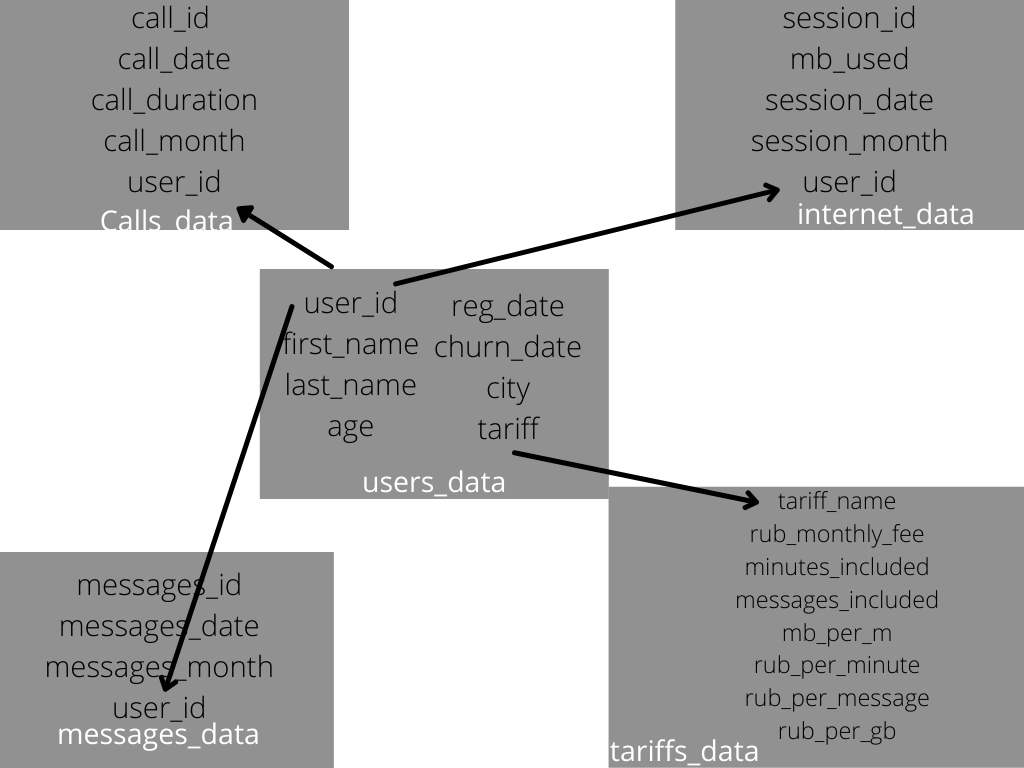

In [24]:
calls_data.head()

,call_id,call_date,call_duration,user_id,call_month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


<AxesSubplot:>

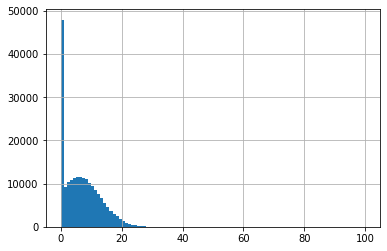

In [25]:
calls_data['call_duration'].hist(range=(0, 100), bins=100)

<div class="alert alert-info"> Как мы видим много звонков с нулём в длительности, учитывая что Мегалайн округляет вверх каждый звонок, то и звонок условно 0.1 минуты он бы округлял до минуты, соответветственно все те записи, где длительность звонка равна нулю можно умножить на ноль.</div>


In [26]:
calls_data = calls_data.query('call_duration > 0')

<div class="alert alert-info">
    Округлим звонки в верхнюю сторону, т.к. это делает мегалайн.
</div>

In [28]:
print('Средняя длина разговора',calls_data['call_duration'].mean())
print('Дисперсия по длине разговора',np.var(calls_data['call_duration']))
print('Стандартное отклонение по длине разговора',np.std(calls_data['call_duration'],ddof=1))

Средняя длина разговора 8.39779402922807
Дисперсия по длине разговора 28.65466965300041
Стандартное отклонение по длине разговора 5.353022086267679


<AxesSubplot:xlabel='call_month', ylabel='call_duration'>

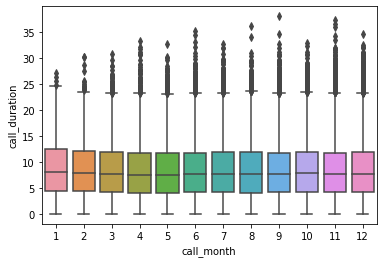

In [29]:
sns.boxplot( x=calls_data["call_month"], y=calls_data["call_duration"])

<div class="alert alert-info"> 
Как видим в данных присутствуют вбросы
</div>

Рассчитаем количество сделанных звонков с агрегацией по пользователю и месяцу. Честно пытался сначала сделать по пользователю с агрегацией по месяцу(чтобы было 12 еще колонок), но не понял как к ним всем применить одно и то же условие для подсчёта прибыли.

In [30]:
calls_data_pivot = calls_data.pivot_table(index = ['user_id', 'call_month'], values = 'call_duration', aggfunc=['count', 'sum'])
calls_data_pivot

count           sum
                   call_duration call_duration
user_id call_month                            
1000    5                     17        150.06
        6                     28        158.90
        7                     41        318.80
        8                     42        389.87
        9                     46        440.14
...                          ...           ...
1498    10                    30        232.63
1499    9                      8         64.65
        10                    44        429.91
        11                    62        576.50
        12                    56        465.16

[3168 rows x 2 columns]

In [31]:
calls_data_pivot.columns = ['call_count', 'minutes_total']
calls_data_pivot['minutes_total']=np.ceil(calls_data_pivot['minutes_total'])
calls_data_pivot

call_count  minutes_total
user_id call_month                           
1000    5                   17          151.0
        6                   28          159.0
        7                   41          319.0
        8                   42          390.0
        9                   46          441.0
...                        ...            ...
1498    10                  30          233.0
1499    9                    8           65.0
        10                  44          430.0
        11                  62          577.0
        12                  56          466.0

[3168 rows x 2 columns]

<div class="alert alert-info">
        
    
    
Вот теперь мы округлили как делает мегалайн. Он округляет минуты в конце месяца, мы сейчас так и сделали.
</div>

Рассчитаем количество отправленых сообщений с агрегацией по пользователю и месяцу.

In [32]:
messages_data.head()

,messages_id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


<AxesSubplot:xlabel='message_month', ylabel='Count'>

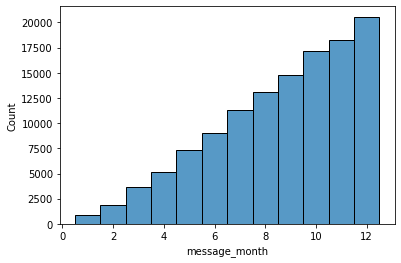

In [33]:
sns.histplot(data=messages_data, x='message_month', discrete=True)

<div class="alert alert-info"> Странно, что в каждом последующем месяце сообщений больше чем в предыдушем.</div>

In [34]:
user_messages = messages_data.groupby('user_id')['messages_id'].count()
print('Средняя количество сообщений отправленных пользователем',user_messages.mean())
print('Дисперсия по количеству сообщений отправленных пользователем',np.var(user_messages))
print('Стандартное отклонение по количеству сообщений отправленных пользователем',np.std(user_messages,ddof=1))

Средняя количество сообщений отправленных пользователем 288.8169014084507
Дисперсия по количеству сообщений отправленных пользователем 71445.6941744363
Стандартное отклонение по количеству сообщений отправленных пользователем 267.6075516313784


<AxesSubplot:>

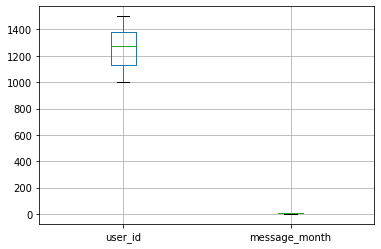

In [35]:
messages_data.boxplot() 

In [36]:
messages_data_pivot = messages_data.pivot_table(index = ['user_id', 'message_month'], values = 'messages_id', aggfunc='count')
messages_data_pivot.columns = ['message_count']
messages_data_pivot

message_count
user_id message_month               
1000    5                         22
        6                         60
        7                         75
        8                         81
        9                         57
...                              ...
1498    10                        42
1499    9                         11
        10                        48
        11                        59
        12                        66

[2717 rows x 1 columns]

Рассчитаем объем израсходованного интернет-трафика с группировкой по пользователю в разрезе по месяцам

<AxesSubplot:>

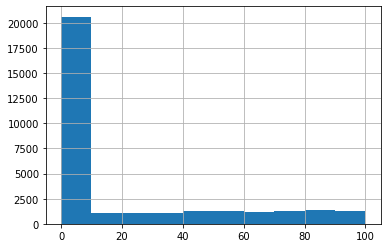

In [37]:
internet_data['mb_used'].hist(range=(0, 100))

In [39]:
internet_data = internet_data.query('mb_used > 0')

In [40]:
print('Среднее количество потребляемого трафика',internet_data['mb_used'].mean())
print('Дисперсия по количеству потребляемого трафика',np.var(internet_data['mb_used']))
print('Стандартное отклонение по количеству потребляемого трафика',np.std(internet_data['mb_used'],ddof=1))

Среднее количество потребляемого трафика 426.08721035763267
Дисперсия по количеству потребляемого трафика 65329.040565885436
Стандартное отклонение по количеству потребляемого трафика 255.5964473206066


In [41]:
internet_data_pivot = internet_data.pivot_table(index = ['user_id', 'session_month'], values = 'mb_used', aggfunc='sum')
internet_data_pivot

mb_used
user_id session_month          
1000    5               2253.49
        6              23233.77
        7              14003.64
        8              14055.93
        9              14568.91
...                         ...
1498    10             20579.36
1499    9               1845.75
        10             17788.51
        11             17963.31
        12             13055.58

[3201 rows x 1 columns]

In [42]:
internet_data_pivot.columns = ['mb_total']
internet_data_pivot['mb_total']=np.ceil(internet_data_pivot['mb_total'])
internet_data_pivot

mb_total
user_id session_month          
1000    5                2254.0
        6               23234.0
        7               14004.0
        8               14056.0
        9               14569.0
...                         ...
1498    10              20580.0
1499    9                1846.0
        10              17789.0
        11              17964.0
        12              13056.0

[3201 rows x 1 columns]

Посчитаем помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;остаток умножить на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
Для того, чтобы это всё сделать нам необходимо все таблицы сделанные нами ранее объединить в одну большую.

In [43]:
join_all_pivot = calls_data_pivot.join ([messages_data_pivot, internet_data_pivot], how='outer')
join_all_pivot.head(12)

call_count  minutes_total  message_count  mb_total
user_id                                                       
1000    5         17.0          151.0           22.0    2254.0
        6         28.0          159.0           60.0   23234.0
        7         41.0          319.0           75.0   14004.0
        8         42.0          390.0           81.0   14056.0
        9         46.0          441.0           57.0   14569.0
        10        44.0          329.0           73.0   14703.0
        11        37.0          320.0           58.0   14757.0
        12        38.0          313.0           70.0    9818.0
1001    11        45.0          409.0            NaN   18430.0
        12        47.0          392.0            NaN   14037.0
1002    6         14.0          111.0            4.0   10857.0
        7         21.0          205.0           11.0   17581.0

In [44]:
#есть пустые значения заменим их на ноль
join_all_pivot['call_count'] = join_all_pivot['call_count'].fillna(0)
join_all_pivot['minutes_total'] = join_all_pivot['minutes_total'].fillna(0)
join_all_pivot['message_count'] = join_all_pivot['message_count'].fillna(0)
join_all_pivot['mb_total'] = np.ceil (join_all_pivot['mb_total']).fillna(0)

In [45]:
users_tariff =  users_data[['user_id', 'tariff']].set_index('user_id')
join_all_pivot = join_all_pivot.join(users_tariff, how='outer')
join_all_pivot.head()

call_count  minutes_total  message_count  mb_total tariff
user_id                                                             
1000    5        17.0          151.0           22.0    2254.0  ultra
        6        28.0          159.0           60.0   23234.0  ultra
        7        41.0          319.0           75.0   14004.0  ultra
        8        42.0          390.0           81.0   14056.0  ultra
        9        46.0          441.0           57.0   14569.0  ultra

array([[<AxesSubplot:title={'center':'call_count'}>,
        <AxesSubplot:title={'center':'minutes_total'}>],
       [<AxesSubplot:title={'center':'message_count'}>,
        <AxesSubplot:title={'center':'mb_total'}>]], dtype=object)

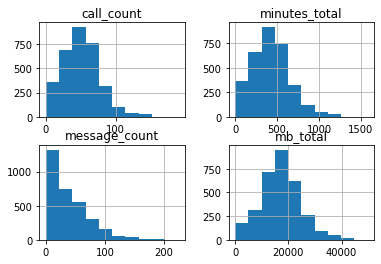

In [46]:
join_all_pivot.hist()

<div class="alert alert-info"> Практически по всем показателям мы видим приятное глазу нормальное распределение. Единственное на кого это правило не распространяется - это сообщения.
 До этого мы смотрели на ситуацию в целом, сейчас мы будем смотреть в зависимости от типа тарифа.
</div>

In [47]:
pivot_ultra = join_all_pivot.query('tariff == "ultra"')
pivot_smart = join_all_pivot.query('tariff == "smart"')

In [48]:
print('Среднее количество звонков для ультра',pivot_ultra['call_count'].mean())
print('Дисперсия по количеству звонков для ультра',np.var(pivot_ultra['call_count']))
print('Стандартное отклонение по количеству звонков для ультра',np.std(pivot_ultra['call_count'],ddof=1))
print()
print('Среднее количество звонков для смарт',pivot_smart['call_count'].mean())
print('Дисперсия по количеству звонков для смарт',np.var(pivot_smart['call_count']))
print('Стандартное отклонение по количеству звонков для смарт',np.std(pivot_smart['call_count'],ddof=1))

Среднее количество звонков для ультра 59.236548223350255
Дисперсия по количеству звонков для ультра 1263.4232327552888
Стандартное отклонение по количеству звонков для ультра 35.56272204788665

Среднее количество звонков для смарт 46.94751009421265
Дисперсия по количеству звонков для смарт 442.44811964155355
Стандартное отклонение по количеству звонков для смарт 21.039170729226214


In [49]:
print('Средняя продолжительность звонков для ультра',pivot_ultra['minutes_total'].mean())
print('Дисперсия по продолжительности звонков для ультра',np.var(pivot_ultra['minutes_total']))
print('Стандартное отклонение по продолжительности звонков для ультра',np.std(pivot_ultra['minutes_total'],ddof=1))
print()
print('Средняя продолжительность звонков для смарт',pivot_smart['minutes_total'].mean())
print('Дисперсия по продолжительности звонков для смарт',np.var(pivot_smart['minutes_total']))
print('Стандартное отклонение по продолжительности звонков для смарт',np.std(pivot_smart['minutes_total'],ddof=1))

Средняя продолжительность звонков для ультра 497.5472081218274
Дисперсия по продолжительности звонков для ультра 89866.39193382979
Стандартное отклонение по продолжительности звонков для ультра 299.9295243351492

Средняя продолжительность звонков для смарт 394.92238672050246
Дисперсия по продолжительности звонков для смарт 32378.373069942867
Стандартное отклонение по продолжительности звонков для смарт 179.9802921249086


In [50]:
print('Среднее количество смс для ультра',pivot_ultra['message_count'].mean())
print('Дисперсия по количеству смс для ультра',np.var(pivot_ultra['message_count']))
print('Стандартное отклонение по количеству смс для ультра',np.std(pivot_ultra['message_count'],ddof=1))
print()
print('Среднее количество смс для смарт',pivot_smart['message_count'].mean())
print('Дисперсия по количеству смс для смарт',np.var(pivot_smart['message_count']))
print('Стандартное отклонение по количеству смс для смарт',np.std(pivot_smart['message_count'],ddof=1))

Среднее количество смс для ультра 49.36345177664975
Дисперсия по количеству смс для ультра 2282.9460753948824
Стандартное отклонение по количеству смс для ультра 47.80445735017472

Среднее количество смс для смарт 33.384028712427096
Дисперсия по количеству смс для смарт 796.455482917076
Стандартное отклонение по количеству смс для смарт 28.22787555676141


In [51]:
print('Среднее количество потребляемых мбайт для ультра',pivot_ultra['mb_total'].mean())
print('Дисперсия по количеству потребляемых мбайт для ультра',np.var(pivot_ultra['mb_total']))
print('Стандартное отклонение по количеству потребляемых мбайт для ультра',np.std(pivot_ultra['mb_total'],ddof=1))
print()
print('Среднее количество потребляемых мбайт смарт',pivot_smart['mb_total'].mean())
print('Дисперсия по количеству потребляемых мбайт для смарт',np.var(pivot_smart['mb_total']))
print('Стандартное отклонение по количеству потребляемых мбайт для смарт',np.std(pivot_smart['mb_total'],ddof=1))

Среднее количество потребляемых мбайт для ультра 19469.308629441624
Дисперсия по количеству потребляемых мбайт для ультра 101648256.8915499
Стандартное отклонение по количеству потребляемых мбайт для ультра 10087.197726109402

Среднее количество потребляемых мбайт смарт 16208.873485868102
Дисперсия по количеству потребляемых мбайт для смарт 34447101.80902782
Стандартное отклонение по количеству потребляемых мбайт для смарт 5870.482331652921


<AxesSubplot:xlabel='tariff', ylabel='call_count'>

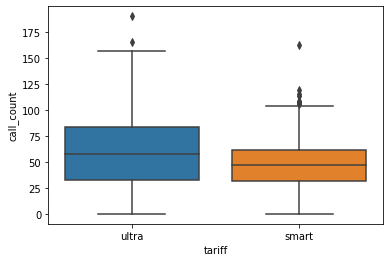

In [52]:
sns.boxplot( x=join_all_pivot["tariff"], y=join_all_pivot["call_count"])

<AxesSubplot:xlabel='tariff', ylabel='minutes_total'>

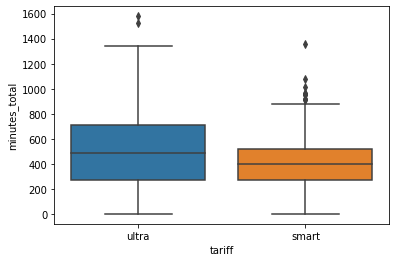

In [53]:
sns.boxplot( x=join_all_pivot["tariff"], y=join_all_pivot["minutes_total"])

<AxesSubplot:xlabel='tariff', ylabel='message_count'>

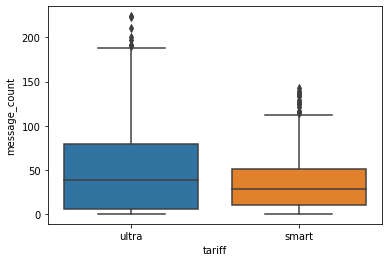

In [54]:
sns.boxplot( x=join_all_pivot["tariff"], y=join_all_pivot["message_count"])

<AxesSubplot:xlabel='tariff', ylabel='mb_total'>

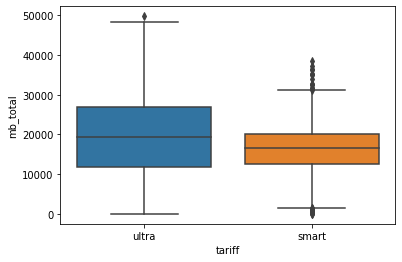

In [55]:
sns.boxplot( x=join_all_pivot["tariff"], y=join_all_pivot["mb_total"])

<div class="alert alert-info"> Убираю убирание выбросов.</div>

Считаем выручку.

In [62]:
join_all_pivot['income']=0.0

Напишем функции, чтобы посчитать сумму прибыли по каждой категории (звонки, сообщения, интернет)

In [63]:
def calculate_call_income(row):
    tariff = row['tariff']
    income = row['income']
    minutes = row['minutes_total']
    if tariff == 'ultra':
        if minutes < 3000.0:
            income = income
        elif minutes >= 3000.0:
            income = income + (minutes - 3000.0)
    elif tariff == 'smart':       
        if minutes < 500.0:
            income = income
        elif minutes >= 500.0:
            income = income + (minutes - 500.0) * 3
    return income

In [64]:
def calculate_sms_income(row):
    tariff = row['tariff']
    income = row['income']
    messags = row['message_count']
    if tariff == 'ultra':
        if messags < 1000.0:
            income = income
        elif messags >= 1000.0:
            income = income + (messags - 1000.0)
    elif tariff == 'smart':       
        if messags < 50.0:
            income = income
        elif messags >= 50.0:
            income = income + (messags - 50.0) * 3
    return income

In [86]:
def calculate_session_income(row):
    tariff = row['tariff']
    income = row['income']
    mb_all = np.ceil(row['mb_total']/1024) # вот здесь надо округлить вверх
    if tariff == 'ultra':
        if mb_all < 30.0:
            income = income
        elif mb_all >= 30.0:
            income = income + (mb_all - 30.0) * 150
    elif tariff == 'smart':       
        if mb_all < 15:
            income = income
        elif mb_all >= 15:
             income = income + (mb_all - 15.0) * 200
    return income

In [66]:
join_all_pivot['income'] = join_all_pivot.apply(calculate_call_income, axis=1)
join_all_pivot['income'] = join_all_pivot.apply(calculate_sms_income, axis=1)
join_all_pivot['income'] = join_all_pivot.apply(calculate_session_income, axis=1)
join_all_pivot

call_count  minutes_total  message_count  mb_total tariff  income
user_id                                                                      
1000    5         17.0          151.0           22.0    2254.0  ultra     0.0
        6         28.0          159.0           60.0   23234.0  ultra     0.0
        7         41.0          319.0           75.0   14004.0  ultra     0.0
        8         42.0          390.0           81.0   14056.0  ultra     0.0
        9         46.0          441.0           57.0   14569.0  ultra     0.0
...                ...            ...            ...       ...    ...     ...
1498    10        30.0          233.0           42.0   20580.0  smart  1200.0
1499    9          8.0           65.0           11.0    1846.0  smart     0.0
        10        44.0          430.0           48.0   17789.0  smart   600.0
        11        62.0          577.0           59.0   17964.0  smart   858.0
        12        56.0          466.0           66.0   13056.0  smart    48.0

[3214 rows x 6 columns]

In [67]:
#Добавим абонентскую плату
join_all_pivot.loc[(join_all_pivot['tariff'] == 'ultra'),'income']= join_all_pivot["income"] + 1950.0
join_all_pivot.loc[ (join_all_pivot['tariff'] == 'smart'),'income']=join_all_pivot["income"] + 550.0       

In [68]:
join_all_pivot

call_count  minutes_total  message_count  mb_total tariff  income
user_id                                                                      
1000    5         17.0          151.0           22.0    2254.0  ultra  1950.0
        6         28.0          159.0           60.0   23234.0  ultra  1950.0
        7         41.0          319.0           75.0   14004.0  ultra  1950.0
        8         42.0          390.0           81.0   14056.0  ultra  1950.0
        9         46.0          441.0           57.0   14569.0  ultra  1950.0
...                ...            ...            ...       ...    ...     ...
1498    10        30.0          233.0           42.0   20580.0  smart  1750.0
1499    9          8.0           65.0           11.0    1846.0  smart   550.0
        10        44.0          430.0           48.0   17789.0  smart  1150.0
        11        62.0          577.0           59.0   17964.0  smart  1408.0
        12        56.0          466.0           66.0   13056.0  smart   598.0

[3214 rows x 6 columns]

Посчитаем общую сумму прибыли по пользователю

In [69]:
user_income = join_all_pivot.groupby('user_id')['income'].sum()
user_income.head()

user_id
1000    15600.0
1001     1700.0
1002     7250.0
1003     9750.0
1004    15600.0
Name: income, dtype: float64

### Вывод из шага
Вы произвели подгтовитлеьную работу и расчитали, несколько показателей
 * количество сделанных звонков и израсходованных минут разговора по месяцам;
 * количество отправленных сообщений по месяцам;
 * объем израсходованного интернет-трафика по месяцам;
 * помесячную выручку с каждого пользователя.
 
Для подсчёта каждого мы сначала сгруппировали необходимые таблица по пользователю и месяцу. В послдствии написав три функции расчитали прибиль для каждого сегмента работ, предлагаемый компанией. После Проссумировали всё прибыли, не забыв добавить к ним сумму за абонентскую плату.

<div class="alert alert-info">
* Также мы убрали из датасета по объему потребялемого трафика те записи, где объем равен нулю, также поступили с датасетом по звонкам
</div>

## Исследования гипотез
**Гипотезы необходимые для проверки**
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; 
 **Нулевая гипотеза - выручка обоих тарифов одинаковы.**
 **Альтерантивная гипотеза - выоручки обоих тарифов различны.**
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
 **Нулевая гипотеза - выручка Москвы и Не москвы одинаковы.**
 **Альтерантивная гипотеза - выручка Москвы и Не москвы различны.**

Соберем все необходимые данные в одну таблицу.

In [70]:
# меняем индекс для будущего merge
users_data.set_index('user_id')

,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_month,reg_month,tariff_type
user_id,,,,,,,,,,
1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1
1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,12,11,0
1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,12,6,0
1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra,12,8,1
1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,12,5,1
...,...,...,...,...,...,...,...,...,...,...
1495,65,2018-12-31,Иркутск,Авксентий,Фокин,2018-08-28,ultra,12,8,1
1496,36,2018-12-31,Вологда,Трифон,Блохин,2018-01-27,smart,12,1,0
1497,32,2018-12-31,Челябинск,Каролина,Агеева,2018-10-09,smart,12,10,0


<div class="alert alert-info">
    
    
    
Таблицу join_all_pivot соединил с таблицей по пользователю, по итогу получил таблицу  прибилью по пользователю в разрезе месяцев. 
</div>

In [71]:
analyze_data = users_data.merge(join_all_pivot, left_on = 'user_id',right_on ='user_id',  how = 'inner') 
analyze_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_x,churn_month,reg_month,tariff_type,call_count,minutes_total,message_count,mb_total,tariff_y,income
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,17.0,151.0,22.0,2254.0,ultra,1950.0
1,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,28.0,159.0,60.0,23234.0,ultra,1950.0
2,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,41.0,319.0,75.0,14004.0,ultra,1950.0
3,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,42.0,390.0,81.0,14056.0,ultra,1950.0
4,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,46.0,441.0,57.0,14569.0,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,7,0,30.0,233.0,42.0,20580.0,smart,1750.0
3210,1499,35,2018-12-31,Пермь,Гектор,Корнилов,2018-09-27,smart,12,9,0,8.0,65.0,11.0,1846.0,smart,550.0
3211,1499,35,2018-12-31,Пермь,Гектор,Корнилов,2018-09-27,smart,12,9,0,44.0,430.0,48.0,17789.0,smart,1150.0
3212,1499,35,2018-12-31,Пермь,Гектор,Корнилов,2018-09-27,smart,12,9,0,62.0,577.0,59.0,17964.0,smart,1408.0


In [72]:
tariff_mean_income = analyze_data.pivot_table(
    index='tariff_x', values='income', aggfunc='mean'
)
tariff_mean_income

,income
tariff_x,
smart,1257.588605
ultra,2070.152284


In [73]:
smart_income = analyze_data.query('tariff_x == "smart"')
ultra_income = analyze_data.query('tariff_x == "ultra"')

<div class="alert alert-info">
Визуализируем распределение по выручке в разрезе по тарифу

</div>

<AxesSubplot:xlabel='tariff_x', ylabel='income'>

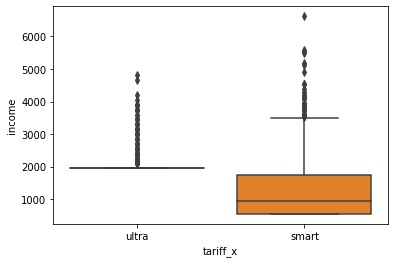

In [74]:
sns.boxplot( x=analyze_data["tariff_x"], y=analyze_data["income"])

In [75]:
print('Дисперия по тарифу смарт',smart_income['income'].var(ddof=1))
print('Дисперия по тарифу ультра ',ultra_income['income'].var(ddof=1))

Дисперия по тарифу смарт 641465.797015512
Дисперия по тарифу ультра  141516.7450786183


In [76]:
# посчитаем равенство дисперсий через тест Барлетта
from scipy.stats import bartlett
stat, p = bartlett(smart_income['income'], ultra_income['income'])
p

8.107523775000117e-135

<div class="alert alert-info">
    Дисперсии действительно не равны
</div>

In [77]:
alpha = .05
results1 = st.ttest_ind (smart_income['income'], ultra_income['income'], equal_var=False) 
# Т.к. дисперии не равны equal_var=False

print ('P-значение:', results1.pvalue)

if (results1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-значение: 6.179723168444486e-274
Отвергаем нулевую гипотезу


Как видно из результатов фактическая разница между выручками за разные тарифы достаточно большая. Отсюда и статистическая проверка гипотезы только подтвердила наши вычислания.

<div class="alert alert-info">


Значение p-value стало равно нулю. Нулевую гипотезу отвергаем.
</div> 
    

Перейдем к провере второй гипотезы. Для простоты подсчёта категоризируем города на москва/не москва

In [78]:
def categorize_city(name, axis):
     if 'Москва' in name:
        category = 'Москва'
        return category
     else:
        category = 'Не Москва'                
        return category

In [79]:
analyze_data['Is_moscow'] = analyze_data['city'].apply(categorize_city,axis=1) 
analyze_data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_x,churn_month,reg_month,tariff_type,call_count,minutes_total,message_count,mb_total,tariff_y,income,Is_moscow
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,17.0,151.0,22.0,2254.0,ultra,1950.0,Не Москва
1,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,28.0,159.0,60.0,23234.0,ultra,1950.0,Не Москва
2,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,41.0,319.0,75.0,14004.0,ultra,1950.0,Не Москва
3,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,42.0,390.0,81.0,14056.0,ultra,1950.0,Не Москва
4,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,5,1,46.0,441.0,57.0,14569.0,ultra,1950.0,Не Москва
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,7,0,30.0,233.0,42.0,20580.0,smart,1750.0,Не Москва
3210,1499,35,2018-12-31,Пермь,Гектор,Корнилов,2018-09-27,smart,12,9,0,8.0,65.0,11.0,1846.0,smart,550.0,Не Москва
3211,1499,35,2018-12-31,Пермь,Гектор,Корнилов,2018-09-27,smart,12,9,0,44.0,430.0,48.0,17789.0,smart,1150.0,Не Москва
3212,1499,35,2018-12-31,Пермь,Гектор,Корнилов,2018-09-27,smart,12,9,0,62.0,577.0,59.0,17964.0,smart,1408.0,Не Москва


In [80]:
city_mean_income = analyze_data.pivot_table(
    index='Is_moscow', values='income', aggfunc='mean'
)
city_mean_income

,income
Is_moscow,
Москва,1526.837971
Не Москва,1501.869766


In [81]:
moscow_income = analyze_data.query('Is_moscow == "Москва"')
not_moscow_income = analyze_data.query('Is_moscow == "Не Москва"')

In [82]:
moscow_income_1 = analyze_data.query('city == "Москва"')
not_moscow_income_1 = analyze_data.query('city != "Москва"')

In [83]:
print('Дисперия по Москве ',moscow_income_1['income'].var(ddof=1))
print('Дисперия по Не Москве ',not_moscow_income_1['income'].var(ddof=1))

Дисперия по Москве  562832.1982935794
Дисперия по Не Москве  644059.3108572472


In [84]:
# посчитаем равенство дисперсий через тест Барлетта
from scipy.stats import bartlett
stat, p = bartlett(moscow_income_1['income'], not_moscow_income_1['income'])
p

0.036722261269905146

In [85]:
alpha = .05
results2 = st.ttest_ind (moscow_income_1['income'], not_moscow_income_1['income'], equal_var=False) 
# Т.к. Дисперии не равны equal_var=False
print ('P-значение:', results2.pvalue)

if (results2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-значение: 0.46532858228722906
Не получилось отвергнуть нулевую гипотезу


А вот тут уже разница в средней выручке не такая существеннная, всего ~400 рублей. Статистическая проверка показала, что несмотря на то, что выручка Москвы отличается от выручки других городов нашей страны, статистически они вероятнее одинаковы.

### Вывод из шага
- Средняя выручка на тарифе смарт и ультра - отличаются;
- Средняя выручка Москвы и средняя вырчка не Москвы не достаточно различны. То есть они сопостовимы.

# Общий вывод


<div class="alert alert-info">
    
### Вывод    
- В данном исследовании был проведено сравнение двух тарифов "Смарт" и "Ультра"

- Основной целью исследования было определить какой из этих двух тарифов наиболее привлекателен для компании. Предварительно обратав все таблицы, добавив необходимые поля и преобразовав все поля в нужный нам формат мы перешли к исследовательскому анализу данных.
    
- В процессе исследовательского анализа были определены (среднее количество, дисперсия и стандартное отклонение) по изучаемым параметрам на всей выборке. При визуальном анализа данных (при построении гистограмм) был выявлен ряд выбросов.
    

<b>Вывод оказался таким - тариф ультра приносит больше денег компании.</b>    
    
-  Посчитав прибыли по тарифам, мы перешли к анализу гипотез.    

1. Проведя статистический анализ мы пришли к выводу, что гипотеза о том, что выручка тарифов смарт и ультра одинакова вероятней должна быть опровергнута - <b> Нулевая гипотеза была отвергнута</b>

2. Гипотеза о том, что выручка Москвы и выручка других городов России одинакова, показала свою статистическую неопровержимость-  <b> Нулевая гипотеза была подтверждена</b>
</div>